In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataset
import random
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import kagglehub
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [ ]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        X, y = self.subset[index]
        if self.transform:
            X = self.transform(X)
        return X, y

    def __len__(self):
        return len(self.subset)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, kernel_size=3, stride=1, reduction=4):
        super().__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = (stride == 1 and in_channels == out_channels)

        layers = []
        # Expansion phase (if expand_ratio != 1)
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(inplace=True)
            ])

        # Depthwise convolution
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True)
        ])

        # Squeeze and Excitation
        layers.append(SEBlock(hidden_dim, reduction=reduction))

        # Projection phase
        layers.extend([
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

class EfficientNet(nn.Module):
    def __init__(self, num_classes=15):
        super().__init__()
        # Stem: initial convolution layer
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True)
        )

        # Define a series of MBConv blocks.
        # The configuration list follows: [in_channels, out_channels, num_blocks, expand_ratio, kernel_size, stride]
        config = [
            [32, 16, 1, 1, 3, 1],
            [16, 24, 2, 6, 3, 2],
            [24, 40, 2, 6, 5, 2],
            [40, 80, 3, 6, 3, 2],
            [80, 112, 3, 6, 5, 1],
            [112, 192, 4, 6, 5, 2],
            [192, 320, 1, 6, 3, 1]
        ]

        blocks = []
        for in_channels, out_channels, num_blocks, expand_ratio, kernel_size, stride in config:
            # First block in each group may have a stride > 1 for downsampling.
            blocks.append(MBConvBlock(in_channels, out_channels, expand_ratio, kernel_size, stride))
            for _ in range(1, num_blocks):
                blocks.append(MBConvBlock(out_channels, out_channels, expand_ratio, kernel_size, stride=1))

        self.blocks = nn.Sequential(*blocks)

        # Head: Final convolution, pooling and classifier
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU(inplace=True)
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
path += "/Aerial_Landscapes"

class RandomMask(nn.Module):
    def __init__(self, num_blocks=3, block_size=50, p=0.5):
        super().__init__()
        self.num_blocks = num_blocks
        self.block_size = block_size
        self.p = p

    def forward(self, img):
        if random.random() < self.p:
            # 获取Tensor格式的尺寸
            c, h, w = img.shape

            for _ in range(self.num_blocks):
                # random block position
                x = random.randint(0, h - self.block_size)
                y = random.randint(0, w - self.block_size)

                # random mask type
                mask_type = random.choice([0, 1, 2])

                if mask_type == 0:  # gray block
                    img[:, x:x+self.block_size, y:y+self.block_size] = 0.5 # 0.5是灰色
                elif mask_type == 1:  # random noise
                    noise = torch.rand_like(img[:, x:x+self.block_size, y:y+self.block_size])
                    img[:, x:x+self.block_size, y:y+self.block_size] = noise
                else: # 不操作
                    pass
        return img

# Define the transformations for the training sets
train_transform = transforms.Compose([
    # PIL
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    # transforms.RandomPerspective(distortion_scale=0.5, p=1.0),
    # 别开这个选项 模型完全没有空间感知能力 开了包炸的
    transforms.RandomRotation(15),

    transforms.ToTensor(),
    # Augmentations for Tensor
    RandomMask(num_blocks=2, block_size=32, p=0.5),
    transforms.RandomErasing(p=0.3),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

generic_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path, transform=None)
dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply the transforms to the datasets
train_dataset = TransformedSubset(train_dataset, train_transform)
val_dataset = TransformedSubset(val_dataset, generic_transform)
test_dataset = TransformedSubset(test_dataset, generic_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 150
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005, nesterov=True) # Yolo v11's parameter, I do not know why, dont modify it, it is perfect
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.3*num_epochs), int(0.6* num_epochs), int(0.9*num_epochs)], gamma=0.1)
# Print the total number of parameters in the modeld
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params}")

best_models = []  # Stores (validation accuracy, epoch, model_state_dict)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    best_accuracy = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / train_size

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= val_size
    accuracy = 100 * correct / total

    print(f"Validation: Accuracy: {accuracy:.2f}%, Loss: {val_loss:.2f}")

    # Save the best 10 models based on validation accuracy
    if len(best_models) < 10:
        best_models.append((accuracy, epoch, copy.deepcopy(model.state_dict())))  # Store a deep copy of the model state
    else:
        # Find the model with the lowest validation accuracy
        min_idx = min(range(len(best_models)), key=lambda i: best_models[i][0])  # Get index of the worst model
        if accuracy > best_models[min_idx][0]:  # Replace only if the current model is better
           best_models[min_idx] = (accuracy, epoch, copy.deepcopy(model.state_dict()))  # Corrected replacement


Total number of parameters: 7162063


Epoch 1/150: 100%|██████████| 150/150 [00:16<00:00,  8.85batch/s, loss=1.55]


Validation: Accuracy: 51.00%, Loss: 1.48


Epoch 2/150: 100%|██████████| 150/150 [00:16<00:00,  9.01batch/s, loss=1.17]


Validation: Accuracy: 53.75%, Loss: 1.36


Epoch 3/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=1.24]


Validation: Accuracy: 62.58%, Loss: 1.12


Epoch 4/150: 100%|██████████| 150/150 [00:16<00:00,  9.14batch/s, loss=1.16]


Validation: Accuracy: 65.67%, Loss: 1.04


Epoch 5/150: 100%|██████████| 150/150 [00:16<00:00,  9.16batch/s, loss=0.949]


Validation: Accuracy: 72.83%, Loss: 0.84


Epoch 6/150: 100%|██████████| 150/150 [00:16<00:00,  9.14batch/s, loss=1.49]


Validation: Accuracy: 71.33%, Loss: 0.83


Epoch 7/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.884]


Validation: Accuracy: 78.33%, Loss: 0.69


Epoch 8/150: 100%|██████████| 150/150 [00:16<00:00,  9.09batch/s, loss=0.797]


Validation: Accuracy: 77.00%, Loss: 0.71


Epoch 9/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.669]


Validation: Accuracy: 81.17%, Loss: 0.60


Epoch 10/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.549]


Validation: Accuracy: 82.17%, Loss: 0.56


Epoch 11/150: 100%|██████████| 150/150 [00:16<00:00,  8.99batch/s, loss=0.633]


Validation: Accuracy: 84.58%, Loss: 0.49


Epoch 12/150: 100%|██████████| 150/150 [00:16<00:00,  9.09batch/s, loss=0.498]


Validation: Accuracy: 80.67%, Loss: 0.60


Epoch 13/150: 100%|██████████| 150/150 [00:16<00:00,  8.98batch/s, loss=0.547]


Validation: Accuracy: 83.08%, Loss: 0.52


Epoch 14/150: 100%|██████████| 150/150 [00:16<00:00,  9.16batch/s, loss=0.598]


Validation: Accuracy: 84.33%, Loss: 0.47


Epoch 15/150: 100%|██████████| 150/150 [00:16<00:00,  9.10batch/s, loss=0.63]


Validation: Accuracy: 84.75%, Loss: 0.47


Epoch 16/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.482]


Validation: Accuracy: 86.58%, Loss: 0.42


Epoch 17/150: 100%|██████████| 150/150 [00:16<00:00,  8.99batch/s, loss=0.625]


Validation: Accuracy: 86.67%, Loss: 0.43


Epoch 18/150: 100%|██████████| 150/150 [00:16<00:00,  9.01batch/s, loss=0.741]


Validation: Accuracy: 86.58%, Loss: 0.41


Epoch 19/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.666]


Validation: Accuracy: 86.92%, Loss: 0.40


Epoch 20/150: 100%|██████████| 150/150 [00:16<00:00,  8.98batch/s, loss=0.404]


Validation: Accuracy: 88.42%, Loss: 0.37


Epoch 21/150: 100%|██████████| 150/150 [00:16<00:00,  9.12batch/s, loss=0.727]


Validation: Accuracy: 87.67%, Loss: 0.36


Epoch 22/150: 100%|██████████| 150/150 [00:16<00:00,  8.93batch/s, loss=0.348]


Validation: Accuracy: 87.00%, Loss: 0.38


Epoch 23/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.558]


Validation: Accuracy: 90.25%, Loss: 0.33


Epoch 24/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.509]


Validation: Accuracy: 90.00%, Loss: 0.32


Epoch 25/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.429]


Validation: Accuracy: 89.08%, Loss: 0.34


Epoch 26/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.42]


Validation: Accuracy: 91.58%, Loss: 0.28


Epoch 27/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.534]


Validation: Accuracy: 89.75%, Loss: 0.30


Epoch 28/150: 100%|██████████| 150/150 [00:16<00:00,  9.06batch/s, loss=0.348]


Validation: Accuracy: 89.83%, Loss: 0.34


Epoch 29/150: 100%|██████████| 150/150 [00:16<00:00,  9.14batch/s, loss=0.433]


Validation: Accuracy: 91.42%, Loss: 0.30


Epoch 30/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.305]


Validation: Accuracy: 90.33%, Loss: 0.30


Epoch 31/150: 100%|██████████| 150/150 [00:16<00:00,  9.10batch/s, loss=0.306]


Validation: Accuracy: 92.00%, Loss: 0.25


Epoch 32/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.606]


Validation: Accuracy: 91.83%, Loss: 0.26


Epoch 33/150: 100%|██████████| 150/150 [00:16<00:00,  9.12batch/s, loss=0.71]


Validation: Accuracy: 92.75%, Loss: 0.26


Epoch 34/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.253]


Validation: Accuracy: 92.00%, Loss: 0.27


Epoch 35/150: 100%|██████████| 150/150 [00:16<00:00,  8.97batch/s, loss=0.351]


Validation: Accuracy: 92.33%, Loss: 0.25


Epoch 36/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.343]


Validation: Accuracy: 92.08%, Loss: 0.22


Epoch 37/150: 100%|██████████| 150/150 [00:16<00:00,  8.98batch/s, loss=0.443]


Validation: Accuracy: 91.92%, Loss: 0.23


Epoch 38/150: 100%|██████████| 150/150 [00:16<00:00,  9.16batch/s, loss=0.591]


Validation: Accuracy: 91.33%, Loss: 0.25


Epoch 39/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.194]


Validation: Accuracy: 92.00%, Loss: 0.27


Epoch 40/150: 100%|██████████| 150/150 [00:16<00:00,  9.09batch/s, loss=0.329]


Validation: Accuracy: 91.83%, Loss: 0.25


Epoch 41/150: 100%|██████████| 150/150 [00:16<00:00,  8.94batch/s, loss=0.14]


Validation: Accuracy: 93.67%, Loss: 0.22


Epoch 42/150: 100%|██████████| 150/150 [00:16<00:00,  9.15batch/s, loss=0.245]


Validation: Accuracy: 92.00%, Loss: 0.24


Epoch 43/150: 100%|██████████| 150/150 [00:16<00:00,  9.10batch/s, loss=0.54]


Validation: Accuracy: 93.25%, Loss: 0.21


Epoch 44/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.47]


Validation: Accuracy: 92.58%, Loss: 0.23


Epoch 45/150: 100%|██████████| 150/150 [00:16<00:00,  9.06batch/s, loss=0.24]


Validation: Accuracy: 93.50%, Loss: 0.20


Epoch 46/150: 100%|██████████| 150/150 [00:16<00:00,  9.07batch/s, loss=0.215]


Validation: Accuracy: 94.33%, Loss: 0.20


Epoch 47/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.455]


Validation: Accuracy: 93.00%, Loss: 0.22


Epoch 48/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.336]


Validation: Accuracy: 94.00%, Loss: 0.20


Epoch 49/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.247]


Validation: Accuracy: 92.42%, Loss: 0.24


Epoch 50/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.323]


Validation: Accuracy: 93.42%, Loss: 0.22


Epoch 51/150: 100%|██████████| 150/150 [00:16<00:00,  8.92batch/s, loss=0.23]


Validation: Accuracy: 93.33%, Loss: 0.21


Epoch 52/150: 100%|██████████| 150/150 [00:16<00:00,  9.19batch/s, loss=0.29]


Validation: Accuracy: 93.67%, Loss: 0.22


Epoch 53/150: 100%|██████████| 150/150 [00:16<00:00,  9.15batch/s, loss=0.227]


Validation: Accuracy: 93.58%, Loss: 0.17


Epoch 54/150: 100%|██████████| 150/150 [00:16<00:00,  8.89batch/s, loss=0.417]


Validation: Accuracy: 94.17%, Loss: 0.18


Epoch 55/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.175]


Validation: Accuracy: 92.92%, Loss: 0.22


Epoch 56/150: 100%|██████████| 150/150 [00:16<00:00,  9.00batch/s, loss=0.262]


Validation: Accuracy: 94.50%, Loss: 0.18


Epoch 57/150: 100%|██████████| 150/150 [00:16<00:00,  9.09batch/s, loss=0.161]


Validation: Accuracy: 93.42%, Loss: 0.20


Epoch 58/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.47]


Validation: Accuracy: 94.50%, Loss: 0.18


Epoch 59/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.181]


Validation: Accuracy: 94.08%, Loss: 0.18


Epoch 60/150: 100%|██████████| 150/150 [00:16<00:00,  9.09batch/s, loss=0.196]


Validation: Accuracy: 94.67%, Loss: 0.19


Epoch 61/150: 100%|██████████| 150/150 [00:16<00:00,  8.95batch/s, loss=0.189]


Validation: Accuracy: 95.17%, Loss: 0.17


Epoch 62/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.222]


Validation: Accuracy: 93.42%, Loss: 0.21


Epoch 63/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.213]


Validation: Accuracy: 93.75%, Loss: 0.20


Epoch 64/150: 100%|██████████| 150/150 [00:16<00:00,  9.01batch/s, loss=0.258]


Validation: Accuracy: 94.33%, Loss: 0.19


Epoch 65/150: 100%|██████████| 150/150 [00:16<00:00,  9.07batch/s, loss=0.382]


Validation: Accuracy: 94.58%, Loss: 0.18


Epoch 66/150: 100%|██████████| 150/150 [00:16<00:00,  9.14batch/s, loss=0.28]


Validation: Accuracy: 94.67%, Loss: 0.18


Epoch 67/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.339]


Validation: Accuracy: 94.83%, Loss: 0.18


Epoch 68/150: 100%|██████████| 150/150 [00:16<00:00,  9.07batch/s, loss=0.357]


Validation: Accuracy: 94.25%, Loss: 0.21


Epoch 69/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.146]


Validation: Accuracy: 94.58%, Loss: 0.19


Epoch 70/150: 100%|██████████| 150/150 [00:16<00:00,  9.14batch/s, loss=0.382]


Validation: Accuracy: 93.33%, Loss: 0.21


Epoch 71/150: 100%|██████████| 150/150 [00:16<00:00,  9.06batch/s, loss=0.259]


Validation: Accuracy: 94.08%, Loss: 0.20


Epoch 72/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.191]


Validation: Accuracy: 94.92%, Loss: 0.17


Epoch 73/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.147]


Validation: Accuracy: 93.50%, Loss: 0.20


Epoch 74/150: 100%|██████████| 150/150 [00:16<00:00,  9.18batch/s, loss=0.0637]


Validation: Accuracy: 93.67%, Loss: 0.20


Epoch 75/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.298]


Validation: Accuracy: 94.08%, Loss: 0.18


Epoch 76/150: 100%|██████████| 150/150 [00:16<00:00,  9.10batch/s, loss=0.132]


Validation: Accuracy: 95.33%, Loss: 0.15


Epoch 77/150: 100%|██████████| 150/150 [00:16<00:00,  9.13batch/s, loss=0.125]


Validation: Accuracy: 94.92%, Loss: 0.17


Epoch 78/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.188]


Validation: Accuracy: 94.75%, Loss: 0.19


Epoch 79/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.282]


Validation: Accuracy: 95.08%, Loss: 0.20


Epoch 80/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.175]


Validation: Accuracy: 94.33%, Loss: 0.20


Epoch 81/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.249]


Validation: Accuracy: 95.25%, Loss: 0.16


Epoch 82/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.151]


Validation: Accuracy: 94.33%, Loss: 0.20


Epoch 83/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.202]


Validation: Accuracy: 94.42%, Loss: 0.20


Epoch 84/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.208]


Validation: Accuracy: 95.25%, Loss: 0.18


Epoch 85/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.189]


Validation: Accuracy: 95.25%, Loss: 0.18


Epoch 86/150: 100%|██████████| 150/150 [00:16<00:00,  9.00batch/s, loss=0.395]


Validation: Accuracy: 94.25%, Loss: 0.20


Epoch 87/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.263]


Validation: Accuracy: 95.67%, Loss: 0.17


Epoch 88/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.084]


Validation: Accuracy: 96.58%, Loss: 0.13


Epoch 89/150: 100%|██████████| 150/150 [00:16<00:00,  8.96batch/s, loss=0.105]


Validation: Accuracy: 94.75%, Loss: 0.16


Epoch 90/150: 100%|██████████| 150/150 [00:16<00:00,  9.01batch/s, loss=0.228]


Validation: Accuracy: 94.83%, Loss: 0.16


Epoch 91/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.0898]


Validation: Accuracy: 95.42%, Loss: 0.15


Epoch 92/150: 100%|██████████| 150/150 [00:16<00:00,  9.07batch/s, loss=0.17]


Validation: Accuracy: 95.50%, Loss: 0.16


Epoch 93/150: 100%|██████████| 150/150 [00:16<00:00,  8.98batch/s, loss=0.0592]


Validation: Accuracy: 95.25%, Loss: 0.16


Epoch 94/150: 100%|██████████| 150/150 [00:16<00:00,  8.88batch/s, loss=0.292]


Validation: Accuracy: 95.42%, Loss: 0.18


Epoch 95/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.126]


Validation: Accuracy: 95.58%, Loss: 0.18


Epoch 96/150: 100%|██████████| 150/150 [00:16<00:00,  9.04batch/s, loss=0.0656]


Validation: Accuracy: 95.75%, Loss: 0.15


Epoch 97/150: 100%|██████████| 150/150 [00:16<00:00,  9.06batch/s, loss=0.221]


Validation: Accuracy: 96.00%, Loss: 0.15


Epoch 98/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.0685]


Validation: Accuracy: 95.50%, Loss: 0.18


Epoch 99/150: 100%|██████████| 150/150 [00:16<00:00,  9.15batch/s, loss=0.315]


Validation: Accuracy: 95.58%, Loss: 0.16


Epoch 100/150: 100%|██████████| 150/150 [00:16<00:00,  8.88batch/s, loss=0.265]


Validation: Accuracy: 96.42%, Loss: 0.14


Epoch 101/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.111]


Validation: Accuracy: 94.67%, Loss: 0.18


Epoch 102/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.0517]


Validation: Accuracy: 95.25%, Loss: 0.16


Epoch 103/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.329]


Validation: Accuracy: 95.83%, Loss: 0.15


Epoch 104/150: 100%|██████████| 150/150 [00:16<00:00,  9.07batch/s, loss=0.172]


Validation: Accuracy: 95.67%, Loss: 0.16


Epoch 105/150: 100%|██████████| 150/150 [00:16<00:00,  9.14batch/s, loss=0.246]


Validation: Accuracy: 95.50%, Loss: 0.16


Epoch 106/150: 100%|██████████| 150/150 [00:16<00:00,  9.07batch/s, loss=0.079]


Validation: Accuracy: 96.33%, Loss: 0.13


Epoch 107/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.225]


Validation: Accuracy: 96.17%, Loss: 0.14


Epoch 108/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.125]


Validation: Accuracy: 95.42%, Loss: 0.17


Epoch 109/150: 100%|██████████| 150/150 [00:16<00:00,  9.12batch/s, loss=0.072]


Validation: Accuracy: 95.67%, Loss: 0.18


Epoch 110/150: 100%|██████████| 150/150 [00:16<00:00,  9.10batch/s, loss=0.188]


Validation: Accuracy: 95.50%, Loss: 0.17


Epoch 111/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.301]


Validation: Accuracy: 94.58%, Loss: 0.19


Epoch 112/150: 100%|██████████| 150/150 [00:16<00:00,  9.07batch/s, loss=0.14]


Validation: Accuracy: 95.08%, Loss: 0.21


Epoch 113/150: 100%|██████████| 150/150 [00:16<00:00,  9.19batch/s, loss=0.056]


Validation: Accuracy: 95.75%, Loss: 0.17


Epoch 114/150: 100%|██████████| 150/150 [00:16<00:00,  8.90batch/s, loss=0.156]


Validation: Accuracy: 94.83%, Loss: 0.19


Epoch 115/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.213]


Validation: Accuracy: 96.17%, Loss: 0.14


Epoch 116/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.0788]


Validation: Accuracy: 95.50%, Loss: 0.19


Epoch 117/150: 100%|██████████| 150/150 [00:16<00:00,  8.87batch/s, loss=0.245]


Validation: Accuracy: 96.00%, Loss: 0.16


Epoch 118/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.154]


Validation: Accuracy: 94.33%, Loss: 0.22


Epoch 119/150: 100%|██████████| 150/150 [00:16<00:00,  8.95batch/s, loss=0.17]


Validation: Accuracy: 94.83%, Loss: 0.19


Epoch 120/150: 100%|██████████| 150/150 [00:16<00:00,  8.99batch/s, loss=0.297]


Validation: Accuracy: 94.92%, Loss: 0.17


Epoch 121/150: 100%|██████████| 150/150 [00:16<00:00,  8.99batch/s, loss=0.344]


Validation: Accuracy: 95.17%, Loss: 0.18


Epoch 122/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.24]


Validation: Accuracy: 96.17%, Loss: 0.15


Epoch 123/150: 100%|██████████| 150/150 [00:16<00:00,  8.96batch/s, loss=0.203]


Validation: Accuracy: 95.92%, Loss: 0.15


Epoch 124/150: 100%|██████████| 150/150 [00:16<00:00,  9.03batch/s, loss=0.129]


Validation: Accuracy: 95.58%, Loss: 0.17


Epoch 125/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.166]


Validation: Accuracy: 95.58%, Loss: 0.15


Epoch 126/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.356]


Validation: Accuracy: 96.25%, Loss: 0.13


Epoch 127/150: 100%|██████████| 150/150 [00:16<00:00,  8.90batch/s, loss=0.29]


Validation: Accuracy: 95.58%, Loss: 0.16


Epoch 128/150: 100%|██████████| 150/150 [00:16<00:00,  9.12batch/s, loss=0.168]


Validation: Accuracy: 96.00%, Loss: 0.16


Epoch 129/150: 100%|██████████| 150/150 [00:17<00:00,  8.78batch/s, loss=0.304]


Validation: Accuracy: 95.33%, Loss: 0.15


Epoch 130/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.0939]


Validation: Accuracy: 95.67%, Loss: 0.18


Epoch 131/150: 100%|██████████| 150/150 [00:16<00:00,  8.89batch/s, loss=0.209]


Validation: Accuracy: 95.58%, Loss: 0.14


Epoch 132/150: 100%|██████████| 150/150 [00:16<00:00,  9.10batch/s, loss=0.0793]


Validation: Accuracy: 95.75%, Loss: 0.15


Epoch 133/150: 100%|██████████| 150/150 [00:17<00:00,  8.82batch/s, loss=0.0414]


Validation: Accuracy: 95.00%, Loss: 0.16


Epoch 134/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.117]


Validation: Accuracy: 96.42%, Loss: 0.15


Epoch 135/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.0827]


Validation: Accuracy: 95.92%, Loss: 0.15


Epoch 136/150: 100%|██████████| 150/150 [00:16<00:00,  8.97batch/s, loss=0.338]


Validation: Accuracy: 95.17%, Loss: 0.19


Epoch 137/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.267]


Validation: Accuracy: 95.50%, Loss: 0.19


Epoch 138/150: 100%|██████████| 150/150 [00:16<00:00,  9.05batch/s, loss=0.145]


Validation: Accuracy: 95.08%, Loss: 0.19


Epoch 139/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.163]


Validation: Accuracy: 96.92%, Loss: 0.14


Epoch 140/150: 100%|██████████| 150/150 [00:16<00:00,  9.12batch/s, loss=0.113]


Validation: Accuracy: 96.08%, Loss: 0.15


Epoch 141/150: 100%|██████████| 150/150 [00:16<00:00,  9.11batch/s, loss=0.167]


Validation: Accuracy: 96.00%, Loss: 0.16


Epoch 142/150: 100%|██████████| 150/150 [00:16<00:00,  9.06batch/s, loss=0.164]


Validation: Accuracy: 96.00%, Loss: 0.16


Epoch 143/150: 100%|██████████| 150/150 [00:16<00:00,  9.09batch/s, loss=0.205]


Validation: Accuracy: 96.42%, Loss: 0.15


Epoch 144/150: 100%|██████████| 150/150 [00:16<00:00,  9.09batch/s, loss=0.062]


Validation: Accuracy: 95.58%, Loss: 0.17


Epoch 145/150: 100%|██████████| 150/150 [00:16<00:00,  9.02batch/s, loss=0.199]


Validation: Accuracy: 95.50%, Loss: 0.18


Epoch 146/150: 100%|██████████| 150/150 [00:16<00:00,  9.08batch/s, loss=0.17]


Validation: Accuracy: 96.00%, Loss: 0.15


Epoch 147/150: 100%|██████████| 150/150 [00:16<00:00,  9.01batch/s, loss=0.0397]


Validation: Accuracy: 96.17%, Loss: 0.14


Epoch 148/150: 100%|██████████| 150/150 [00:16<00:00,  9.00batch/s, loss=0.071]


Validation: Accuracy: 96.75%, Loss: 0.17


Epoch 149/150: 100%|██████████| 150/150 [00:16<00:00,  9.10batch/s, loss=0.0616]


Validation: Accuracy: 95.42%, Loss: 0.19


Epoch 150/150: 100%|██████████| 150/150 [00:16<00:00,  9.12batch/s, loss=0.191]


Validation: Accuracy: 95.75%, Loss: 0.17


Model from Epoch 100 (Val Acc: 96.42%) -> Test Accuracy: 95.58%
Model from Epoch 148 (Val Acc: 96.75%) -> Test Accuracy: 95.50%
Model from Epoch 122 (Val Acc: 96.17%) -> Test Accuracy: 95.50%
Model from Epoch 134 (Val Acc: 96.42%) -> Test Accuracy: 95.83%
Model from Epoch 115 (Val Acc: 96.17%) -> Test Accuracy: 95.92%
Model from Epoch 126 (Val Acc: 96.25%) -> Test Accuracy: 96.25%
Model from Epoch 139 (Val Acc: 96.92%) -> Test Accuracy: 96.08%
Model from Epoch 88 (Val Acc: 96.58%) -> Test Accuracy: 95.58%
Model from Epoch 143 (Val Acc: 96.42%) -> Test Accuracy: 95.92%
Model from Epoch 106 (Val Acc: 96.33%) -> Test Accuracy: 94.92%

Best Model on Test Set: Epoch 126 with Test Accuracy: 96.25%


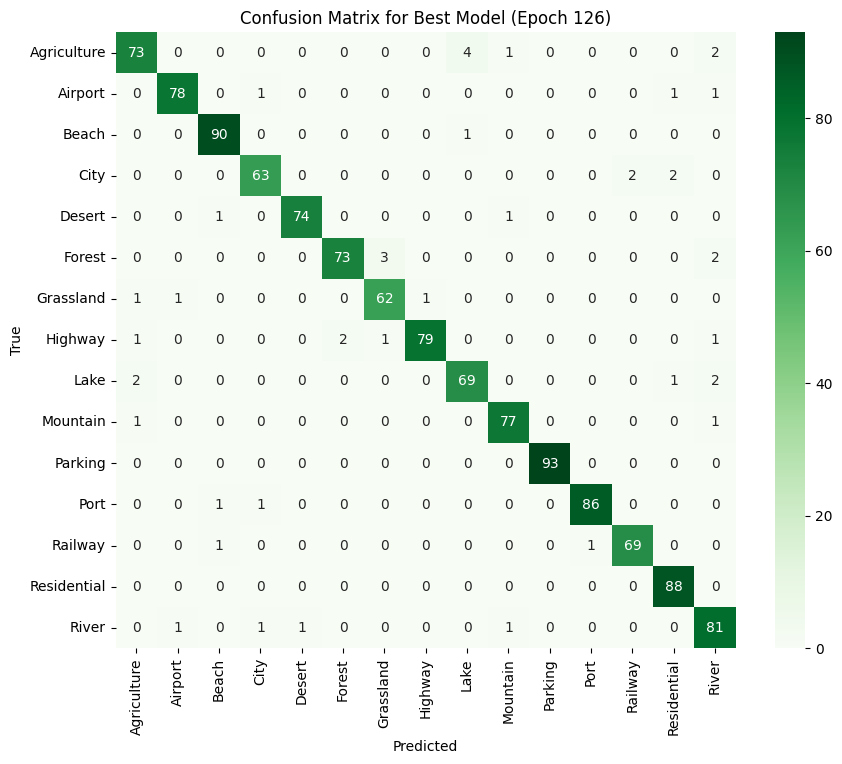

In [6]:
best_test_results = []

for val_acc, epoch, model_state in best_models:
    model.load_state_dict(model_state)  # Load model state from memory
    model.eval()

    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Model from Epoch {epoch+1} (Val Acc: {val_acc:.2f}%) -> Test Accuracy: {test_accuracy:.2f}%")

    best_test_results.append((test_accuracy, epoch, model_state, all_labels, all_predictions))

# Find the model with the highest test accuracy
best_test_results.sort(key=lambda x: x[0], reverse=True)
best_model_test = best_test_results[0]
best_test_acc, best_epoch, best_model_state, best_labels, best_predictions = best_model_test

print(f"\nBest Model on Test Set: Epoch {best_epoch+1} with Test Accuracy: {best_test_acc:.2f}%")

# Display the confusion matrix for the best model
cm = confusion_matrix(best_labels, best_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Best Model (Epoch {best_epoch+1})')
plt.show()